# Portfolio Optimization with Fama-French Factor Model

This project aims 1) to build a factor-based model allocation namely a Long/Short Global Macro Strategy with a Target Beta and 2) to evaluate its sensitivity to variations of Beta and its sensitivity to the length of the estimators for covariance matrix and the expected returns under different market scenarios.

#### Please run the code of Part 1 - Part 5.1 directly. Then, set the target backtesting periods in the 1st cell of Part 5.2, and run all of the rest of code.

In [1]:
%%capture
import pandas as pd
import numpy as np
import copy
import itertools
import statsmodels.api as sm # for linear regresion
from cvxopt import matrix, solvers
from cvxopt.solvers import qp
solvers.options['show_progress'] = False
from scipy.stats import skew, kurtosis
from scipy.stats import norm
import seaborn as sns
sns.set() 

%matplotlib inline     
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore")

In [2]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (24, 12),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
plt.rcParams.update(params) 

## Part 1: Import & Process Data 

## Part 1-1 Import Data
- We fetch data from the websites and save it as csv files:

In [3]:
url = 'https://drive.google.com/uc?export=download&id=1zYT4qlPzdNb4c4b4cFBaFzHxZCXdIIGt'
adjclose = pd.read_csv(url, parse_dates=['Date'], index_col = 'Date', dayfirst = True)
logReturn = np.log(adjclose).diff().dropna()
logReturn.head()

,DBA,EPP,EWJ,FEZ,FXE,GLD,ILF,QQQ,SHV,SPY,USO,XBI
Date,,,,,,,,,,,,
2007-03-02,-0.009429,-0.010946,-0.016473,-0.013280,0.000682,-0.032582,-0.020821,-0.015186,0.000550,-0.013182,-0.004499,-0.024782
2007-03-05,-0.001896,-0.031251,-0.014639,-0.018116,-0.007605,-0.012319,-0.023162,-0.007799,-0.000183,-0.009564,-0.027628,-0.008908
2007-03-06,-0.005329,0.040209,0.023596,0.027998,0.002669,0.019201,0.048096,0.016472,0.000092,0.016965,0.014009,0.012148
2007-03-07,0.009119,-0.003429,-0.002060,-0.001893,0.004406,0.002336,-0.008425,-0.003975,0.000367,-0.001003,0.019093,-0.003889
2007-03-08,-0.000757,0.011991,0.008895,0.010179,-0.003188,0.002795,0.019828,0.006772,0.000092,0.008419,0.000000,0.004104


In [4]:
url = 'https://drive.google.com/uc?export=download&id=13cB_WCvBqF3b9r8fXl3ar0LEHwDW5QeR'
# Reference Website: 
# French, K. R. Data Library. 
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
factors = pd.read_csv(url, index_col = 0)
factors.index = pd.to_datetime(factors.index, format = '%Y%m%d')
factors = factors.iloc[1:-1,:]
factors.head()

,Mkt-RF,SMB,HML,RF
2007-03-02,-1.24,-0.64,0.26,0.019
2007-03-05,-1.11,-0.69,-0.31,0.019
2007-03-06,1.58,0.65,-0.02,0.019
2007-03-07,-0.21,-0.09,0.08,0.019
2007-03-08,0.68,-0.03,-0.06,0.019


## Part 2: Build French Fama 3-factor model

In [5]:
def FF3_Reg(logReturn, factors):
    
    excess_logReturn = logReturn.values - factors['RF'].values.reshape(len(factors['RF']),1)
    
    reg = pd.DataFrame(index = logReturn.index, columns = logReturn.columns)
    for i in range(len(logReturn.columns)):
        x = factors[["Mkt-RF", "SMB", "HML"]]
        y = excess_logReturn[:,i]
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        olsres = model.fit()
        reg.iloc[:,i] = olsres.predict(x) + factors['RF']
    
    return reg

## Part 3: Optimization

In [6]:
def Optimization(logReturn, factors, w_previous, today, days_return, days_cov):
    n = len(logReturn.columns)
    today_idx = logReturn.index.get_indexer([today])[0]
    df_expRet = FF3_Reg(logReturn.iloc[today_idx-days_cov:today_idx, :], factors.iloc[today_idx-days_cov:today_idx, :])
    P = matrix(np.cov(df_expRet.T))
    df_expRet = FF3_Reg(logReturn.iloc[today_idx-days_return:today_idx, :], factors.iloc[today_idx-days_return:today_idx, :])
    q = matrix(-np.sum(df_expRet, axis = 0)- w_previous@P) # considering the weights of the last period

    G1 = matrix(0.0, (n,n))
    G1[::n+1] = 1.0
    G = matrix([G1, -G1])
    h = matrix(2.0, (n*2,1))

    beta_matrix = []
    for i in range(len(logReturn.columns)):
        beta_matrix.append(np.cov(df_expRet.iloc[:,i], logReturn['SPY'][today_idx-days_return:today_idx])[1,0])

    beta_matrix = matrix(np.array(beta_matrix)/ np.var(logReturn['SPY'][today_idx-days_return:today_idx], ddof=1))
    A1 = matrix(1.0, (1,n))
    A = matrix([beta_matrix.T, A1])
    b = matrix([Beta_target, 1.0])
    w = qp(P, q, G, h, A, b)['x']
    return w

## Part 4: Output Weight Data

In [7]:
# days_return period could be 20, 80, 140
days_return_L = [20, 80, 140]
days_cov_L = [20, 80, 140]

# Beta_target could be -1, -0.5, 0, 0.5, 1, 1.5
Beta_target_L = [-1, 0, 1]

weight_df = pd.DataFrame(columns = ['return days', 'cov days', 'Beta', 'Start Date'] + logReturn.columns.tolist())

for days_return, days_cov, Beta_target in itertools.product(days_return_L, days_cov_L, Beta_target_L):
#     print('return days: ', days_return, 'cov days: ', days_cov, 'Beta: ', Beta_target) # processing log
    day_pass = days_return if days_return > days_cov else days_cov
    dates = pd.DataFrame(logReturn.index)
    dates = dates.iloc[day_pass+1:,:]
    g = dates.groupby(pd.Grouper(key='Date', freq='W'))  # frequency = weekly
    dates = [group.iloc[0,0] for _,group in g]

    n = len(logReturn.columns)
    w_previous = np.ones(n)/n
    for today in dates: 
        w = Optimization(logReturn, factors, w_previous, today, days_return, days_cov)
        weight_df = weight_df.append({'return days':days_return, 'cov days': days_cov, 'Beta': Beta_target, 'Start Date': today}, ignore_index=True)
        weight_df.iloc[-1,4:] = pd.Series(w).values
        w_previous = weight_df.iloc[-1,4:].values

In [8]:
df_benchmark = pd.DataFrame(columns = ['return days', 'cov days', 'Beta', 'Start Date']+ logReturn.columns.tolist())
df_benchmark['Start Date'] = logReturn.index
df_benchmark.loc[:,['return days', 'cov days', 'Beta']] = 'SPY'
df_benchmark['SPY'] = 1
df_benchmark.fillna(0, inplace = True)
weight_df = pd.concat([weight_df, df_benchmark], axis = 0)
weight_df = weight_df.set_index(['return days' , 'cov days', 'Beta'])

In [9]:
weight_df.head()

Start Date       DBA       EPP  EWJ       FEZ  \
return days cov days Beta                                                 
20          20       -1   2007-04-02      -2.0 -1.999997 -2.0  0.335483   
                     -1   2007-04-09      -2.0       2.0 -2.0       2.0   
                     -1   2007-04-16 -1.999919  1.999999 -2.0       2.0   
                     -1   2007-04-23      -2.0      -2.0 -2.0       2.0   
                     -1   2007-04-30      -2.0      -2.0 -2.0  0.990951   

                                FXE       GLD       ILF       QQQ       SHV  \
return days cov days Beta                                                     
20          20       -1    1.999999  1.999999  1.999998      -2.0  0.664518   
                     -1         2.0       2.0 -1.518642      -2.0 -1.481358   
                     -1    1.999999       2.0 -1.205893      -2.0 -1.794186   
                     -1         2.0       2.0  1.282075      -2.0       2.0   
                     -1         2.0 -1.999999  1.999996  1.999999  0.009057   

                                SPY       USO       XBI  
return days cov days Beta                                
20          20       -1        -2.0       2.0  1.999999  
                     -1        -2.0       2.0       2.0  
                     -1        -2.0       2.0       2.0  
                     -1        -2.0 -0.282075       2.0  
                     -1    1.999995      -2.0       2.0

# Part 5: Backtesting

## Part 5-1: Backtesting Funtions

In [10]:
def BacktestingDaily(df_returns, df_weights): 
    df_weights = df_weights.set_index(df_weights.iloc[:,0])
    df_weights.drop(columns = df_weights.columns[0], axis=1, inplace=True)
    
    daily_weights = pd.DataFrame(index = df_returns.index)
    daily_weights = pd.concat([daily_weights, df_weights], axis= 1)
    daily_weights.fillna(method="ffill", inplace = True) # fill the weights to the following cells with no datum
    returns = np.sum(df_returns * daily_weights, axis = 1)
    PV = (returns+1).cumprod() 
    
    daily_report = pd.DataFrame({'PV': PV, 'Daily Returns': returns})
    daily_report.iloc[0,1] =  daily_report.iloc[0,0] - 1 
    return daily_report

In [11]:
def cvar_parametric(portofolioReturns, portfolioStd, alpha=5, dof=6):
    # Reference Website: 
    # (1) Emerick, J. Value at Risk (VaR) and Conditional VaR (CVaR). from QuantPy: 
    # https://quantpy.com.au/risk-management/value-at-risk-var-and-conditional-var-cvar/
    # (2) Burkardt, J. (2014, October 17). The Truncated Normal Distribution.  
    # https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf

    CVaR = portofolioReturns - norm.pdf(norm.ppf(alpha/100)) * portfolioStd / (alpha/100) 
    return CVaR
        
def modified_VaR(returns_mean, sigma, skew, kurt, alpha=5):
    z_score = norm.ppf(alpha/100)
    Z = z_score + (z_score ** 2 - 1) * skew / 6 + (z_score ** 3 - 3 * z_score) * kurt / 24 - (2 * z_score ** 3 - 5 * z_score) * skew ** 2 / 36
    return returns_mean + (sigma * Z)

In [12]:
def AnnulizedAnalysis(daily_report, business_days = 250):
    c = ['Cumulated Return', 'Daily Arithmetic Mean Return', 'Daily Geometric Mean Return', 'Daily Min Return',
        'Max 10 days Drawdown', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Kurtosis', 'Modified VaR', 'CVaR'] 
    
    report = pd.DataFrame(columns = c)
    value = []
    value.append(daily_report['PV'][-1])
    value.append(np.average(daily_report['Daily Returns'], axis = 0) * business_days)
    value.append(np.prod(daily_report['Daily Returns']+1) ** (business_days/len(daily_report.index)) -1)
    value.append(daily_report['Daily Returns'].min())
    value.append(np.nanmean(daily_report['PV'].rolling(10).apply(lambda x: ((x - x.cummax()) / x.cummax()).min()))) 
    value.append(np.std(daily_report['Daily Returns'], ddof = 1) * np.sqrt(business_days))
    # as the function of Sharpe ratio in Performance Analytics Module in R set the default risk-free rate to 0,
    # we set rf = 0, too.
    value.append(value[1]/value[-1]) 
    value.append(skew(daily_report['Daily Returns'])) # for normally distributed data: skewness = 0
    value.append(kurtosis(daily_report['Daily Returns'], fisher=True)) # for normally distributed data, kurtosis = 0
    value.append(modified_VaR(value[1], value[5], value[7], value[8]))
    value.append(cvar_parametric(value[1], value[5], dof=1))
    report.loc[0] = value
    
    return report

## Part 5-2: Backtesting 
Please set the period in the following 1st section.

In [13]:
# Split into three periods
#    - Before Crisis (bc): 2007/1/1 - 2008/1/1
#    - During Crisis (dc): 2008/1/1 - 2011/1/1
#    - After Crisis (ac): 2011/1/1 - 2022/9/30
period_start = "2011/1/1"
period_end = "2022/9/30"

In [14]:
weights = weight_df.loc[(weight_df['Start Date'] >= period_start) & (weight_df['Start Date'] <= period_end),:]
LogReturn = logReturn.loc[(logReturn.index >= period_start) & (logReturn.index <= period_end),:]
g = weights.groupby(level=[0,1,2])  
dfList = [group for _,group in g]

c = ['Cumulated PnL', 'Daily Arithmetic Mean Return', 'Daily Geometric Mean Return', 'Daily Min Return',
        'Max 10 days Drawdown', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Kurtosis', 'Modified VaR', 'CVaR']
report = pd.DataFrame(index = weights.index.unique(), columns = c) # Create Summary Report
PVPlot = pd.DataFrame(index = weights.index.unique()).T # DataFrame for ploting the cummulated daily PnL
dailyReturnPlot = pd.DataFrame(index = weights.index.unique()).T  # DataFrame for ploting the distribution of daily return
for i in range(len(dfList)):
        w = dfList[i]
        r = LogReturn
        DailyReport= BacktestingDaily(r, dfList[i])
        rep = AnnulizedAnalysis(DailyReport)
        report.iloc[i,:] = rep.iloc[0,:]
        PVPlot.iloc[:,i] = DailyReport['PV'] * 100
        dailyReturnPlot.iloc[:,i] = DailyReport['Daily Returns'] * 100

### Summary Report

In [15]:
report

Cumulated PnL Daily Arithmetic Mean Return  \
return days cov days Beta                                              
20          20       -1        0.016504                     0.377644   
                     0         0.062926                      0.46256   
                     1         0.267641                     0.580606   
            80       -1        0.013155                     0.357715   
                     0         0.054773                     0.450548   
                     1         0.235408                      0.56987   
            140      -1        0.013811                     0.360848   
                     0         0.055706                     0.451513   
                     1          0.24409                     0.573115   
80          20       -1         0.02954                     0.459989   
                     0         0.137115                     0.558844   
                     1         0.276463                     0.611016   
            80       -1        0.029373                     0.460661   
                     0         0.134185                     0.557818   
                     1         0.272278                     0.610116   
            140      -1        0.029881                      0.46208   
                     0         0.136535                     0.559039   
                     1         0.275278                     0.611015   
140         20       -1         0.25464                     0.652102   
                     0           1.8442                     0.783299   
                     1         6.525987                     0.884449   
            80       -1        0.258297                     0.653247   
                     0         1.872418                     0.784582   
                     1         6.769861                     0.887728   
            140      -1        0.263597                     0.654905   
                     0         1.872335                      0.78458   
                     1         6.761287                     0.887621   
SPY         SPY      SPY       3.013369                     0.108536   

                          Daily Geometric Mean Return Daily Min Return  \
return days cov days Beta                                                
20          20       -1                     -0.293267        -0.436131   
                     0                       -0.20857        -0.402515   
                     1                      -0.105488         -0.36161   
            80       -1                     -0.306697        -0.436131   
                     0                      -0.217804        -0.402515   
                     1                      -0.115144         -0.36161   
            140      -1                     -0.303836        -0.436131   
                     0                      -0.216685        -0.402515   
                     1                       -0.11243         -0.36161   
80          20       -1                     -0.257602        -0.523307   
                     0                      -0.154682        -0.501355   
                     1                      -0.103032        -0.442648   
            80       -1                     -0.257959        -0.523307   
                     0                      -0.156225        -0.501355   
                     1                      -0.104188        -0.442648   
            140      -1                     -0.256882        -0.523307   
                     0                      -0.154985        -0.501355   
                     1                      -0.103357        -0.442648   
140         20       -1                     -0.109248        -0.538026   
                     0                       0.053126        -0.509993   
                     1                       0.171919        -0.459108   
            80       -1                     -0.108173        -0.538026   
                     0                       0.054479        -0.509993   
               

### Cummulated Daily PnL Graph

In [16]:
add_SPY = False

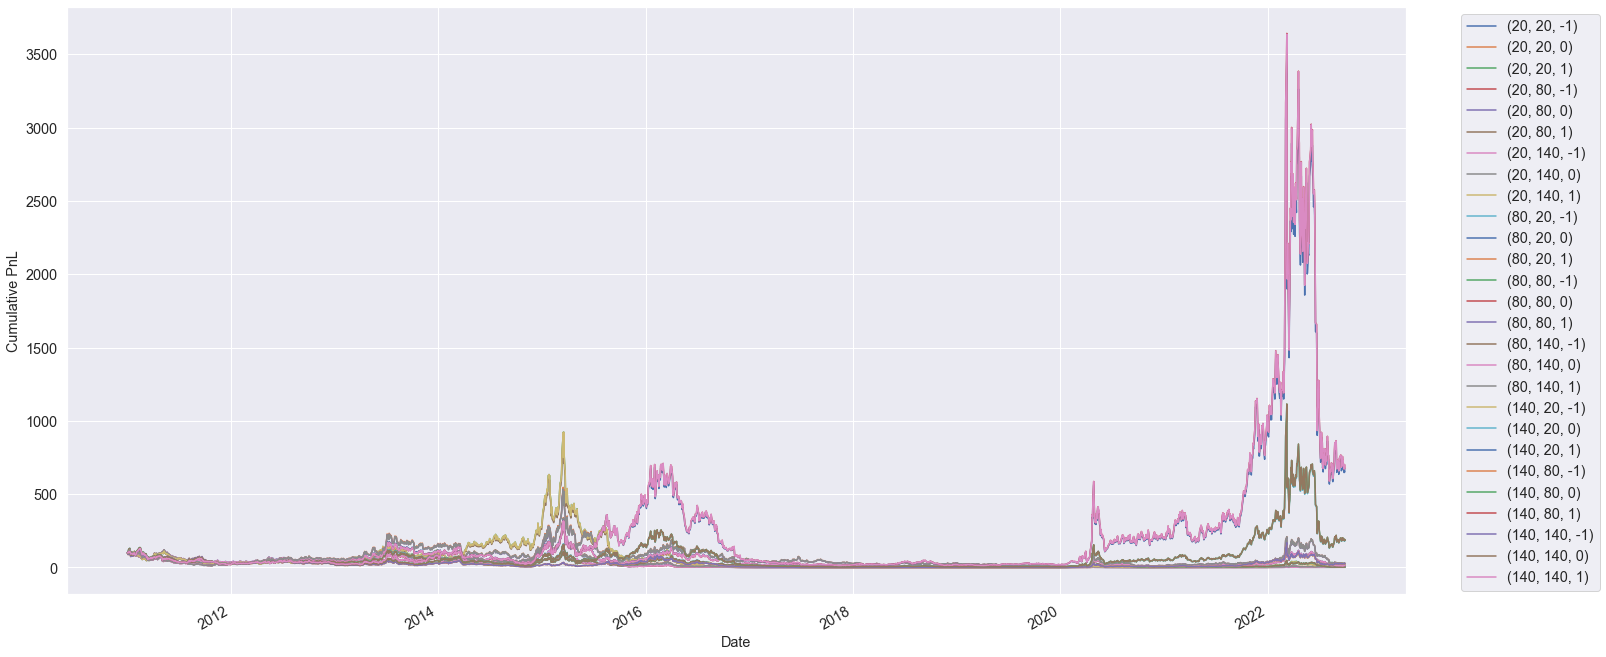

In [17]:
if add_SPY == True:
    PVPlot.iloc[:,:].plot(grid = True, ylabel = "Cumulative PnL")
else:
    PVPlot.iloc[:,:-1].plot(grid = True, ylabel = "Cumulative PnL")

plt.legend(loc = "best")
plt.legend(bbox_to_anchor = (0,0,1.15,1))

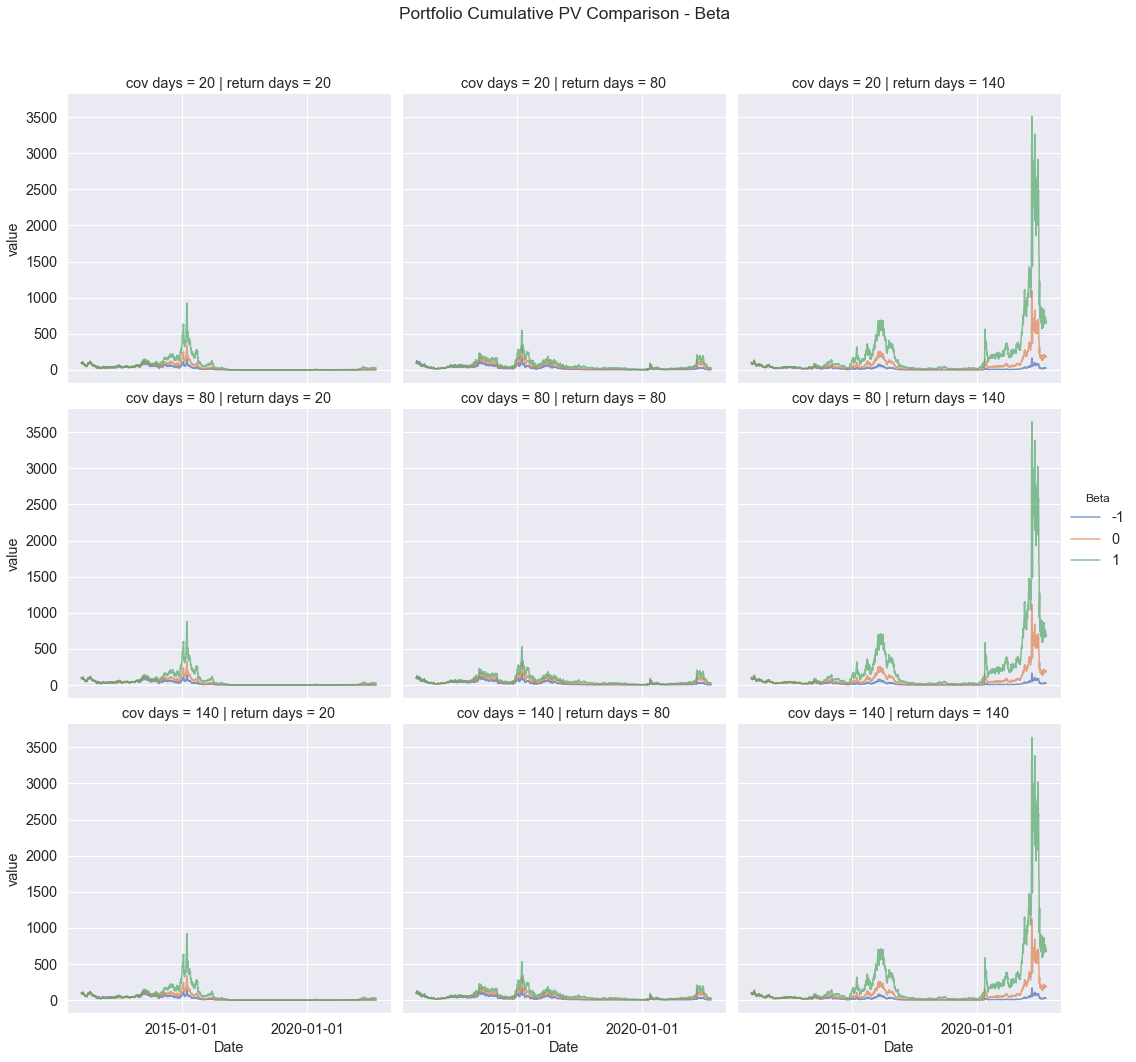

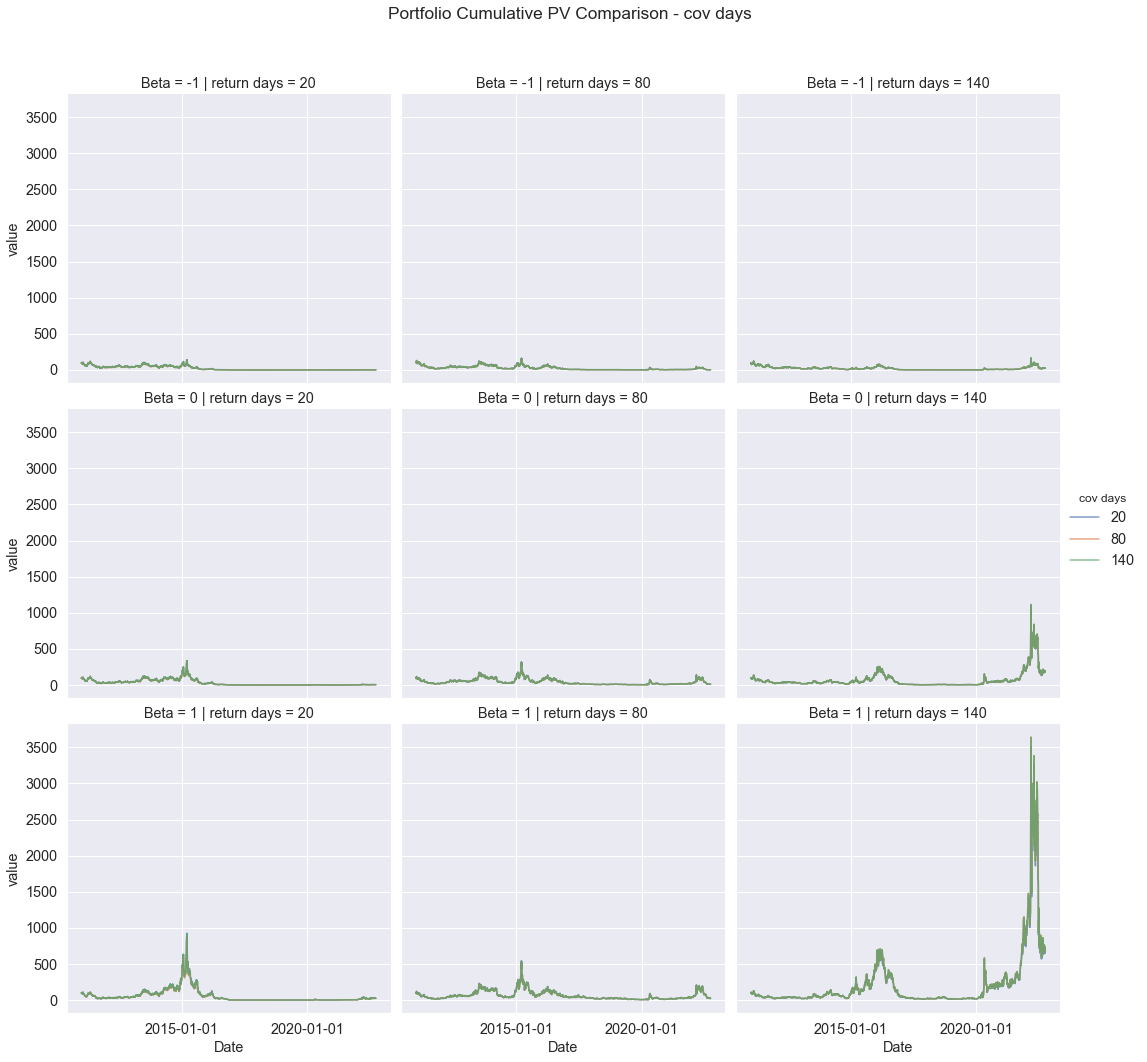

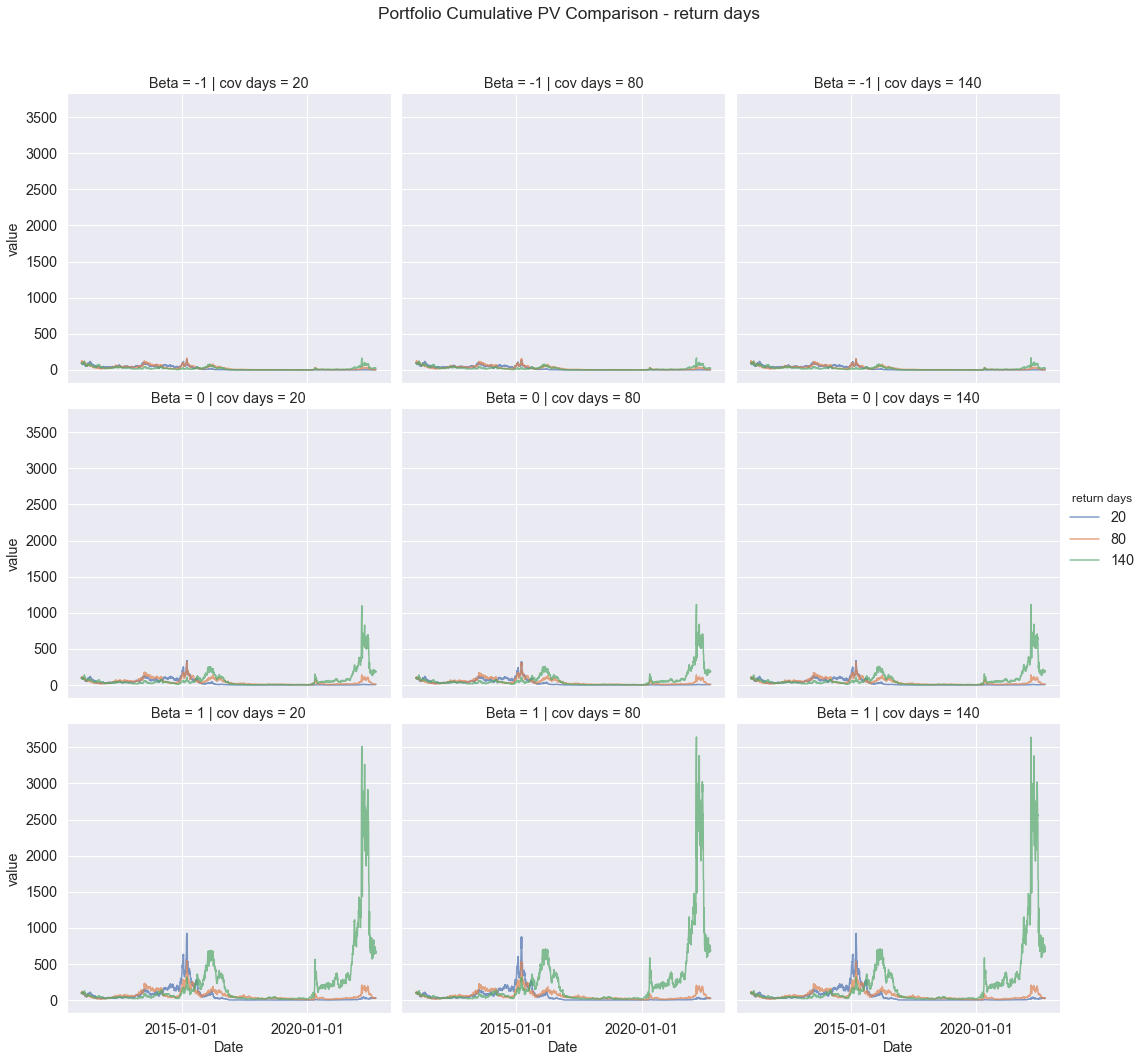

In [18]:
PVPlot_SPY = PVPlot.loc[:,'SPY']
PVPlot2 = PVPlot.drop(columns=['SPY'])
col_List = [('return days','cov days', 'Beta'), ('return days', 'Beta','cov days'),('cov days', 'Beta','return days')]
for _, element in enumerate(col_List):
    PVPlot_temp2 = copy.deepcopy(PVPlot2)
    PVPlot_temp2 = PVPlot_temp2.T
    PVPlot_temp2.reset_index(inplace = True)
    PVPlot_temp2 = pd.melt(PVPlot_temp2,id_vars=['return days','cov days', 'Beta'])
    
    CumPV = sns.FacetGrid(PVPlot_temp2, col =element[0] , row = element[1], hue = element[2], height = 5)
    CumPV.map_dataframe(sns.lineplot,'Date', 'value', alpha = .7)
    CumPV.add_legend()
    CumPV.set_axis_labels('Date', 'value')
    CumPV.axes[0,0].xaxis.set_major_locator(mdates.YearLocator(base = 5))
    CumPV.fig.subplots_adjust(top=0.9)
    CumPV.fig.suptitle('Portfolio Cumulative PV Comparison - {0}'.format(element[2]), fontsize = 'xx-large')

### Daily Return Distribution Graph

In [19]:
add_SPY = False

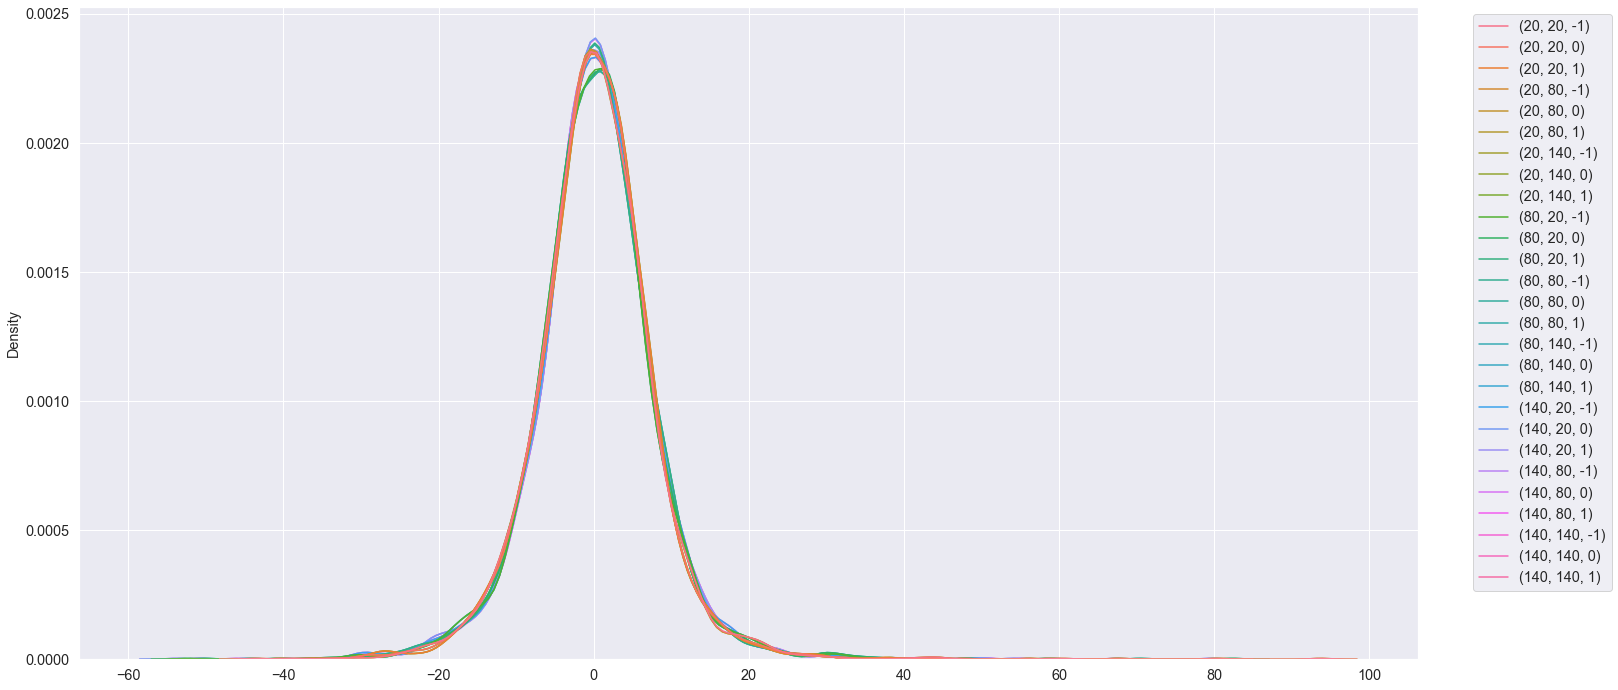

In [20]:
dailyReturnPlot1 = copy.deepcopy(dailyReturnPlot)
dailyReturnPlot1.columns = dailyReturnPlot1.columns.to_flat_index()
if add_SPY == True:
    ax = sns.kdeplot(data=dailyReturnPlot1.iloc[:,:])
else:
    ax = sns.kdeplot(data=dailyReturnPlot1.iloc[:,:-1])
sns.move_legend(ax, loc = 'best', bbox_to_anchor = (0,0,1.15,1))

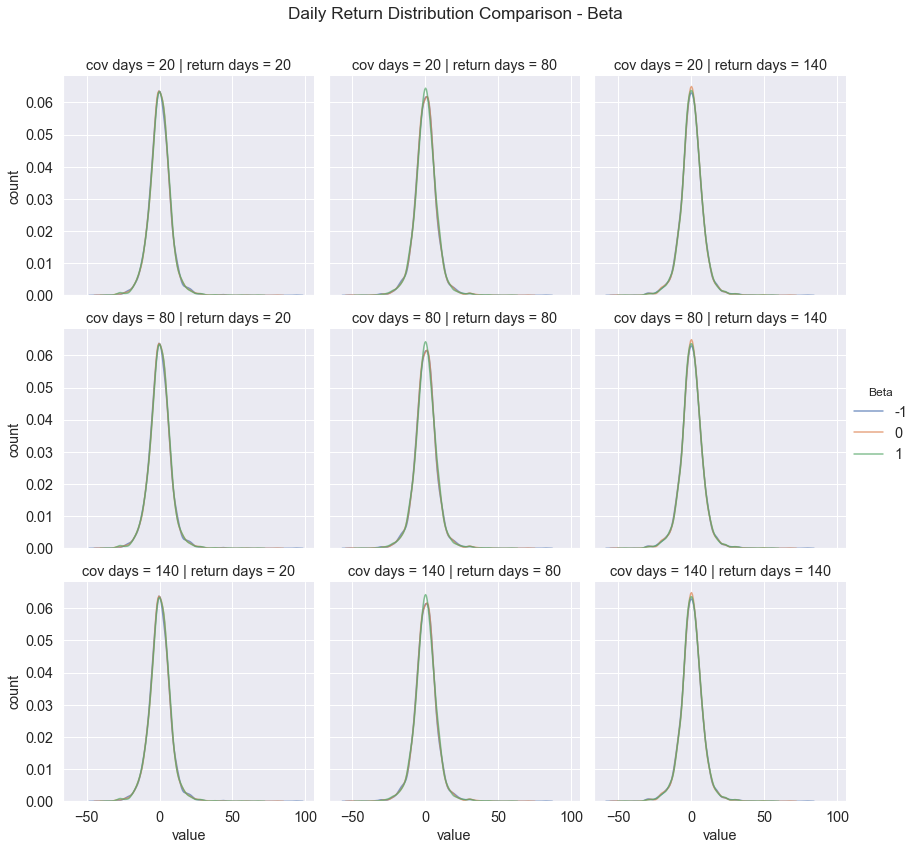

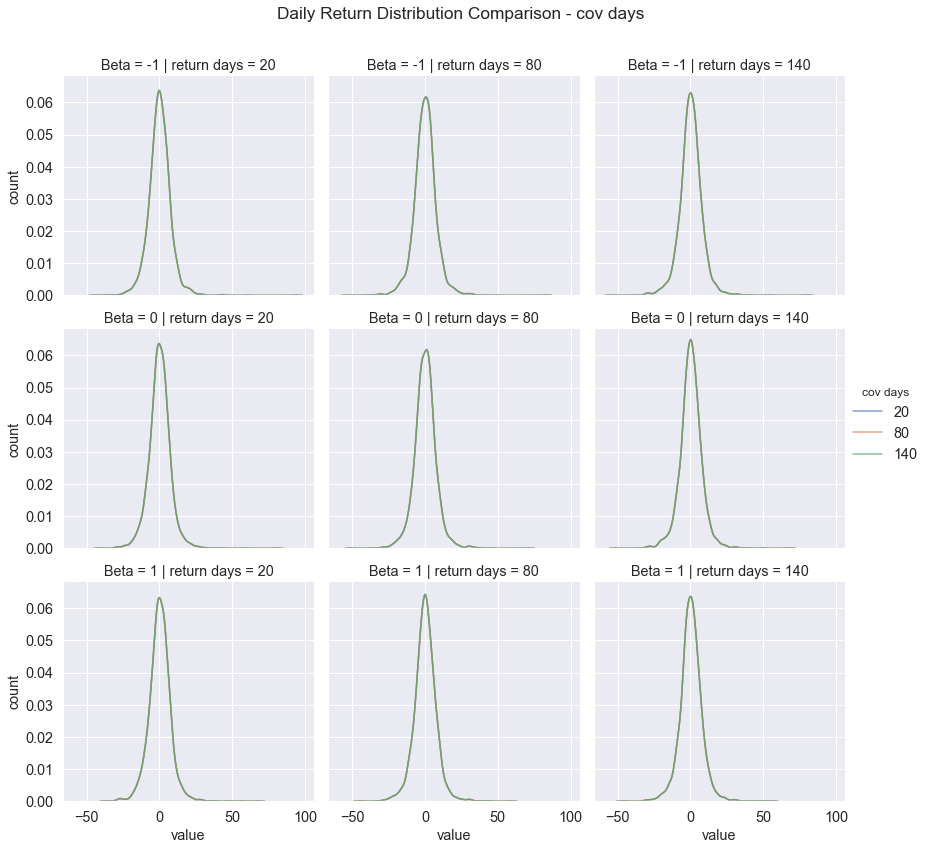

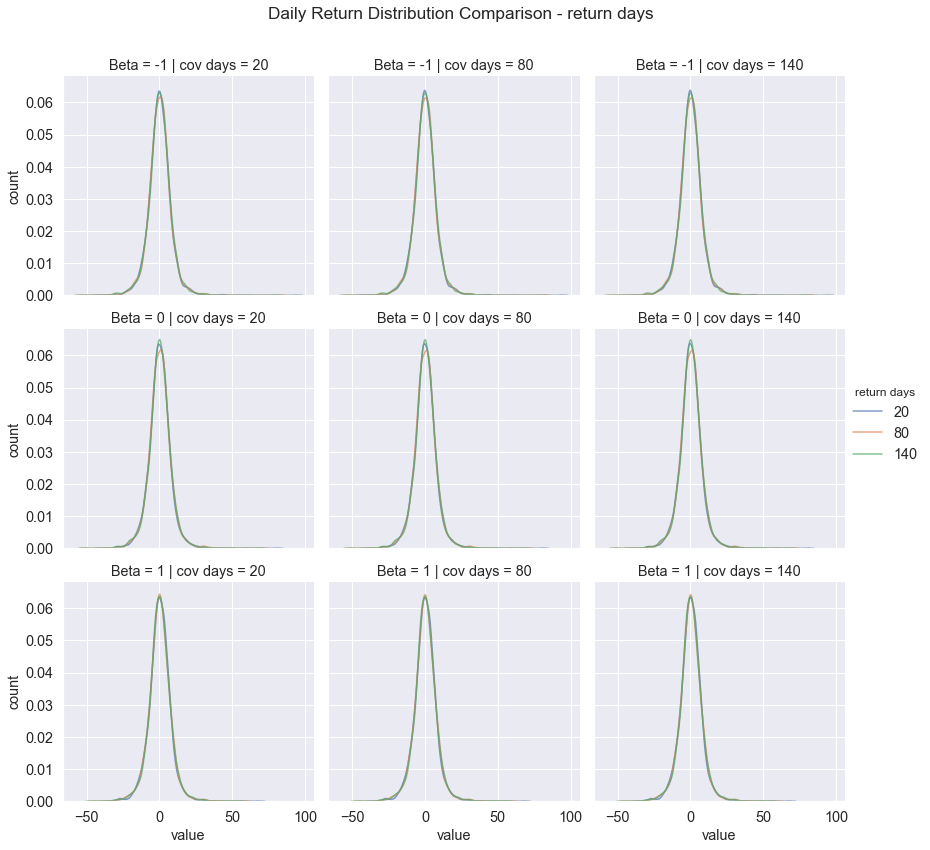

In [21]:
dailyReturnPlot_SPY = dailyReturnPlot.loc[:,'SPY']
dailyReturnPlot2 = dailyReturnPlot.drop(columns=['SPY'])
col_List = [('return days','cov days', 'Beta'), ('return days', 'Beta','cov days'),('cov days', 'Beta','return days')]
for _, element in enumerate(col_List):
    dailyReturnPlot_temp2 = copy.deepcopy(dailyReturnPlot2)
    dailyReturnPlot_temp2 = dailyReturnPlot_temp2.T
    dailyReturnPlot_temp2.reset_index(inplace = True)
    dailyReturnPlot_temp2 = pd.melt(dailyReturnPlot_temp2,id_vars=['return days','cov days', 'Beta'])  

    distribution = sns.FacetGrid(dailyReturnPlot_temp2, col =element[0] , row = element[1], hue = element[2], height = 4)
    distribution.map(sns.kdeplot,'value', alpha = .7)
    distribution.add_legend()
    distribution.set_axis_labels('value', 'count')
    distribution.fig.subplots_adjust(top=0.9)
    distribution.fig.suptitle('Daily Return Distribution Comparison - {0}'.format(element[2]), fontsize = 'xx-large')